<a href="https://colab.research.google.com/github/aymenhmid/NLP_Guide/blob/main/RNN%20and%20LSTM/RNN_Application_In_NLP_Practical_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction to RNNs in NLP <a name="introduction"></a>

Recurrent Neural Networks are specialized neural networks designed to work with sequential data. Unlike feedforward networks, RNNs maintain an internal state (memory) which allows them to process sequences of inputs. This makes them ideally suited for NLP tasks where context and order matter.

### Why RNNs for NLP?

- **Sequential Data**: Language is inherently sequential - the order of words matters!
- **Variable Length**: RNNs can handle inputs and outputs of varying lengths
- **Context Retention**: They can capture dependencies between words separated by many steps
- **Memory**: Information from earlier in a sequence can influence processing later on

### Main RNN Variants

1. **Simple/Vanilla RNN**: Basic recurrent structure with limitations in capturing long-term dependencies
2. **LSTM (Long Short-Term Memory)**: Addresses the vanishing gradient problem with specialized memory cells
3. **GRU (Gated Recurrent Unit)**: Simplified version of LSTM with comparable performance but fewer parameters
4. **Bidirectional RNNs**: Process sequences in both forward and backward directions
5. **RNNs with Attention**: Combine RNNs with attention mechanisms to focus on relevant parts of input

## 2. Setup and Data Preparation

TensorFlow version: 2.18.0
Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded dataset with 25000 training and 25000 testing samples
Train data shape: (25000, 200)
Test data shape: (25000, 200)
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Sample review:
and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the sta

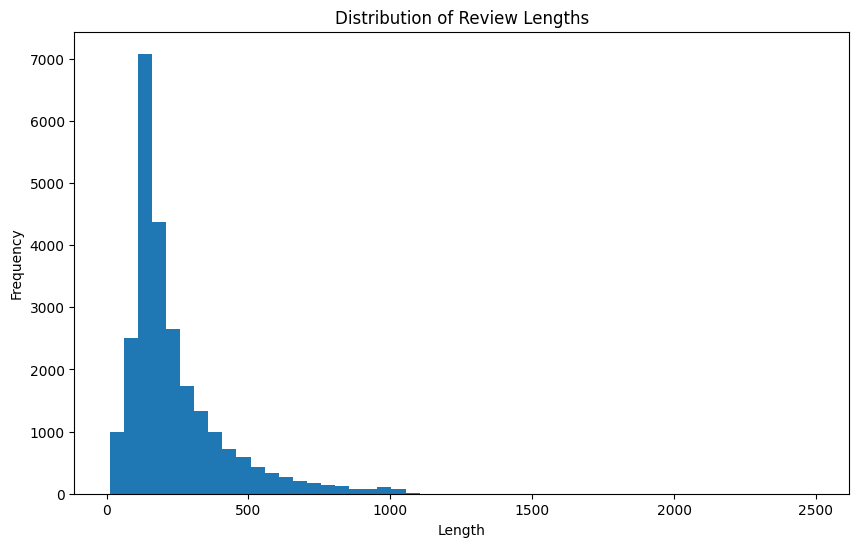

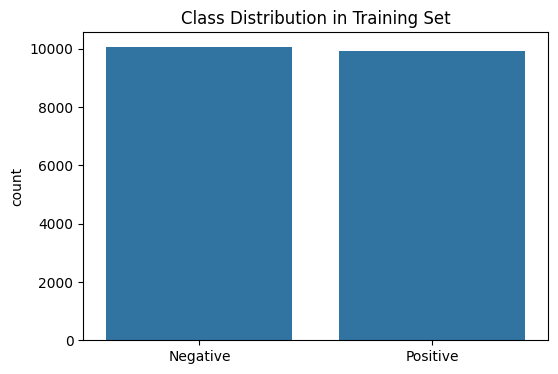

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions
print(f"TensorFlow version: {tf.__version__}")


### Loading the IMDB Dataset

#We'll use the IMDB movie reviews dataset which contains 50,000 movie reviews labeled as positive or negative. This dataset is perfect for sentiment analysis tasks.


# Load the IMDB dataset
max_features = 10000  # Consider only the top 10,000 words
max_len = 200  # Limit reviews to 200 words

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Loaded dataset with {len(x_train)} training and {len(x_test)} testing samples")

# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')
print(f"Train data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Let's look at a sample review
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review if i > 0])

print("\nSample review:")
print(decode_review(x_train[0]))
print(f"Sentiment: {'Positive' if y_train[0] == 1 else 'Negative'}")


# Create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")


### Data Visualization


# Visualize review lengths
review_lengths = [len(x) for x in imdb.load_data(num_words=max_features)[0][0]]
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

## 3. Simple RNN for Sentiment Analysis

Building Simple RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Simple RNN model...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4990 - loss: 0.7156

157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.4991 - loss: 0.7156 - val_accuracy: 0.5240 - val_loss: 0.6898
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5151 - loss: 0.7025

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.5151 - loss: 0.7024 - val_accuracy: 0.5328 - val_loss: 0.6860
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5368 - loss: 0.6898

157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.5369 - loss: 0.6898 - val_accuracy: 0.5188 - val_loss: 0.6849
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5505 - loss: 0.6823

157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.5505 - loss: 0.6822 - val_accuracy: 0.5230 - val_loss: 0.6819
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5588 - loss: 0.6758

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.5588 - loss: 0.6758 - val_accuracy: 0.5250 - val_loss: 0.6776
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5807 - loss: 0.6639

157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.5807 - loss: 0.6639 - val_accuracy: 0.5272 - val_loss: 0.6753
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5858 - loss: 0.6562

157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.5858 - loss: 0.6562 - val_accuracy: 0.5304 - val_loss: 0.6731
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.5885 - loss: 0.6480 - val_accuracy: 0.5340 - val_loss: 0.6751
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.6039 - loss: 0.6362 - val_accuracy: 0.5334 - val_loss: 0.6734
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.6003 - loss: 0.6355 - val_accuracy: 0.5258 - val_loss: 0.6754


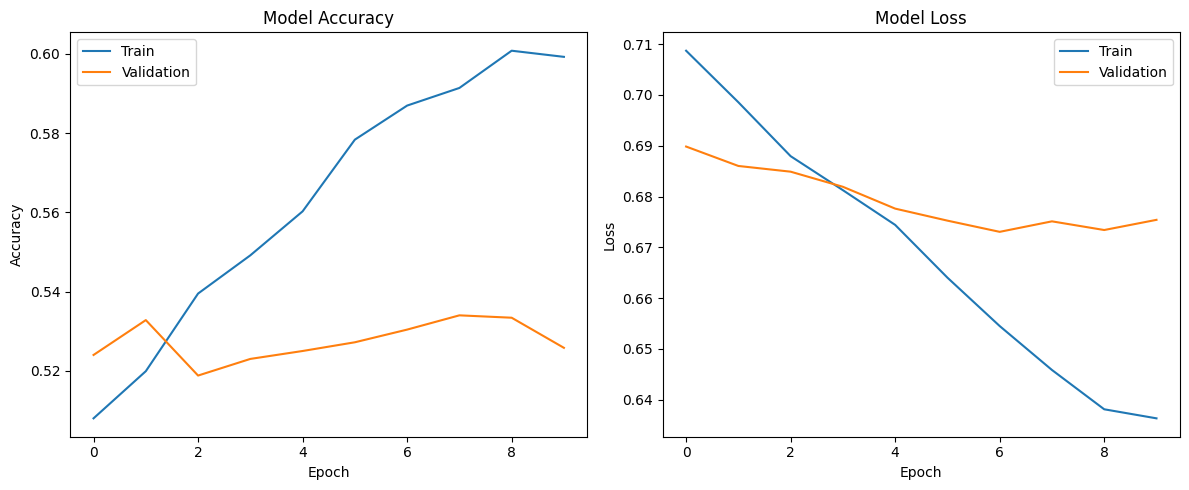


Evaluating Simple RNN model...
Test Loss: 0.6772
Test Accuracy: 0.5290
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64     12500
           1       0.57      0.23      0.33     12500

    accuracy                           0.53     25000
   macro avg       0.54      0.53      0.48     25000
weighted avg       0.54      0.53      0.48     25000



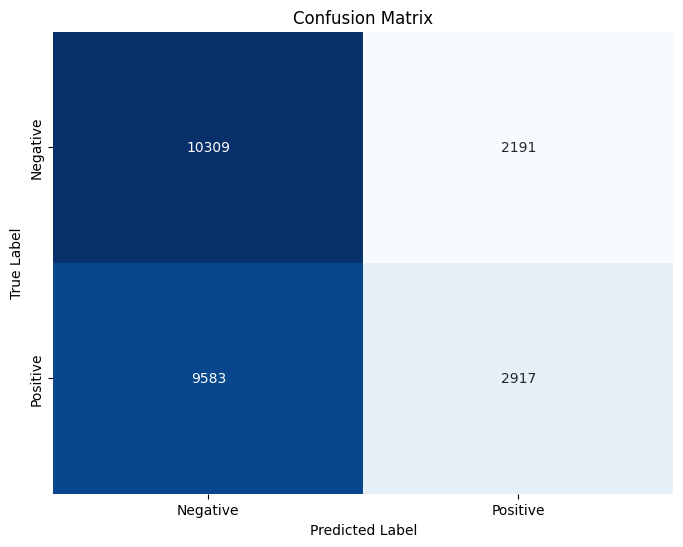


Analysis of Simple RNN Performance:

The Simple RNN provides a baseline performance for sequence modeling in sentiment analysis.
However, it typically struggles with longer sequences due to the vanishing gradient problem,
which makes it difficult to capture long-term dependencies in the text.


Simple RNN Architecture:

Input Sequence: [x₁, x₂, ..., xₙ] (words in a review)
↓
Embedding Layer: Maps each word to a dense vector
↓
For each time step t:
    h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
    where:
    - h_t is the hidden state at time t
    - x_t is the input at time t (embedded word)
    - W_xh is the input-to-hidden weight matrix
    - W_hh is the hidden-to-hidden weight matrix
    - b_h is the bias term
↓
Final hidden state is passed to Dense layer for classification
↓
Output: Sentiment probability (0-1)

The key limitation: As sequences get longer, information from early steps gets "diluted" due to 
repeated multiplication through the recurrent connections, leading to th

In [2]:

def plot_history(history):
    """Function to plot training & validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='best')

    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='best')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_test, y_test):
    """Function to evaluate and display model performance"""
    # Evaluate on test set
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate predictions
    y_pred = (model.predict(x_test) > 0.5).astype(int)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.show()


### Building and Training the Simple RNN Model


print("Building Simple RNN model...")
embedding_dim = 100
rnn_units = 64

# Define a simple RNN model
simple_rnn_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    SimpleRNN(rnn_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
simple_rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
simple_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simple_rnn_model.h5', save_best_only=True)

# Train the model
print("\nTraining Simple RNN model...")
simple_rnn_history = simple_rnn_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plot_history(simple_rnn_history)

# Evaluate the model
print("\nEvaluating Simple RNN model...")
evaluate_model(simple_rnn_model, x_test, y_test)

# Analysis
print("\nAnalysis of Simple RNN Performance:")
print("""
The Simple RNN provides a baseline performance for sequence modeling in sentiment analysis.
However, it typically struggles with longer sequences due to the vanishing gradient problem,
which makes it difficult to capture long-term dependencies in the text.
""")


### Understanding the Simple RNN Architecture


# Visualization of the Simple RNN architecture
from tensorflow.keras.utils import plot_model

# Uncomment to generate model diagram
# plot_model(simple_rnn_model, to_file='simple_rnn_model.png', show_shapes=True, show_layer_names=True)

# Let's manually illustrate how SimpleRNN processes sequences
print("""
Simple RNN Architecture:

Input Sequence: [x₁, x₂, ..., xₙ] (words in a review)
↓
Embedding Layer: Maps each word to a dense vector
↓
For each time step t:
    h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
    where:
    - h_t is the hidden state at time t
    - x_t is the input at time t (embedded word)
    - W_xh is the input-to-hidden weight matrix
    - W_hh is the hidden-to-hidden weight matrix
    - b_h is the bias term
↓
Final hidden state is passed to Dense layer for classification
↓
Output: Sentiment probability (0-1)

The key limitation: As sequences get longer, information from early steps gets "diluted" due to
repeated multiplication through the recurrent connections, leading to the vanishing gradient problem.
""")

## 4. LSTM Networks for Sequence Modeling

Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 469ms/step - accuracy: 0.5308 - loss: 0.6891 - val_accuracy: 0.6990 - val_loss: 0.5715
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - accuracy: 0.6862 - loss: 0.6026 - val_accuracy: 0.7446 - val_loss: 0.5318
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.7719 - loss: 0.5114 - val_accuracy: 0.7918 - val_loss: 0.5089
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 461ms/step - accuracy: 0.7589 - loss: 0.4993 - val_accuracy: 0.6994 - val_loss: 0.6729
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.6426 - loss: 0.6208 - val_accuracy: 0.6428 - val_loss: 0.6000
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.6988 - loss: 0.5255 - val_accuracy: 0.8146 - val_loss: 0.4743
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 478ms/step - accuracy: 0.7791 - loss: 0.4651 - val_accuracy: 0.8154 - val_loss: 0.4585
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 481ms/step - ac

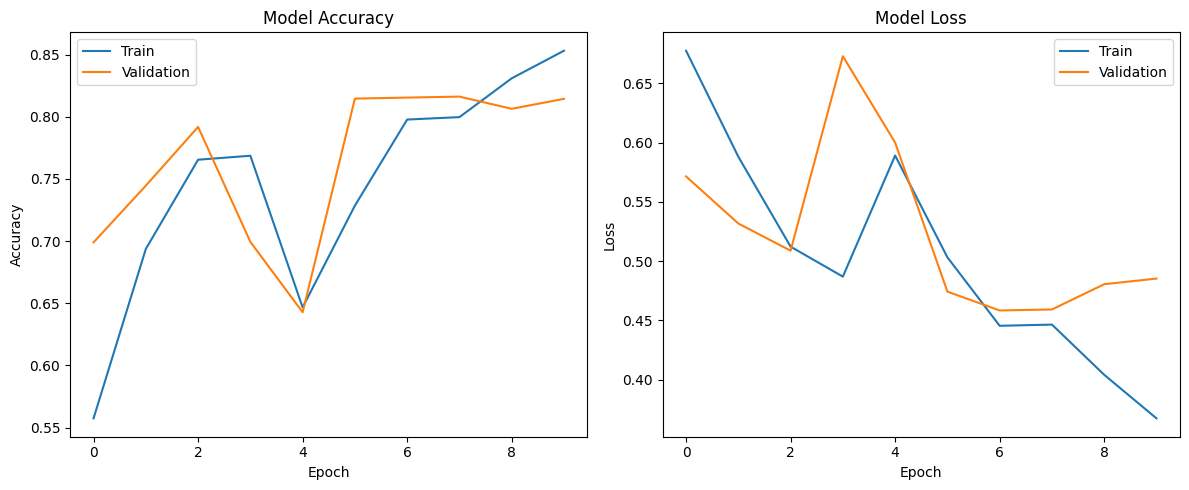


Evaluating LSTM model...
Test Loss: 0.4564
Test Accuracy: 0.8183
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



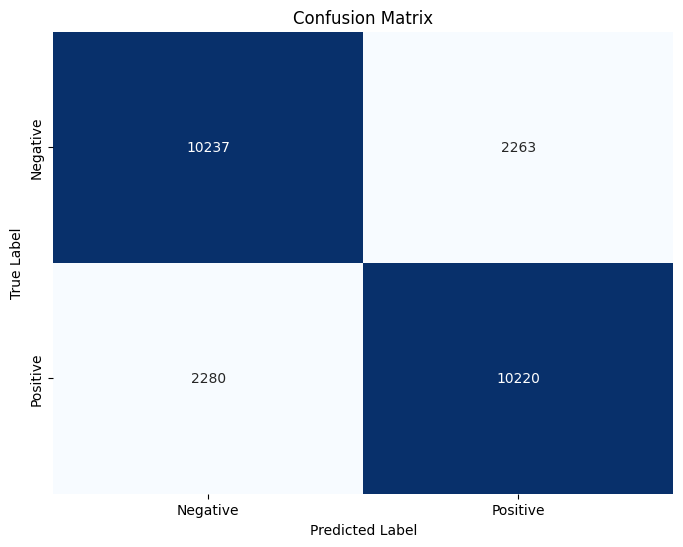


Analysis of LSTM Performance:

The LSTM extends the simple RNN by adding specialized memory cells with gating mechanisms:
- Forget gate: Controls what information to discard from the cell state
- Input gate: Controls what new information to store in the cell state
- Output gate: Controls what parts of the cell state to output

These gates allow LSTMs to maintain information over longer sequences, 
effectively addressing the vanishing gradient problem that limits simple RNNs.
LSTMs can better capture long-term dependencies in text, which is crucial
for tasks like sentiment analysis where the sentiment might depend on words 
that appear far apart in the text.


LSTM Architecture and Internal Mechanics:

LSTM cell contains:
1. Cell state (c_t): Long-term memory that runs through the entire chain
2. Hidden state (h_t): Output for the current time step
3. Gates:
   - Forget gate: f_t = σ(W_f·[h_{t-1}, x_t] + b_f)
   - Input gate: i_t = σ(W_i·[h_{t-1}, x_t] + b_i)
   - Cell candidate: C̃_t 

In [3]:
print("Building LSTM model...")
lstm_units = 64

# Define an LSTM model
lstm_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
lstm_model.summary()

# Train the model
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Plot training history
plot_history(lstm_history)

# Evaluate the model
print("\nEvaluating LSTM model...")
evaluate_model(lstm_model, x_test, y_test)

# Analysis
print("\nAnalysis of LSTM Performance:")
print("""
The LSTM extends the simple RNN by adding specialized memory cells with gating mechanisms:
- Forget gate: Controls what information to discard from the cell state
- Input gate: Controls what new information to store in the cell state
- Output gate: Controls what parts of the cell state to output

These gates allow LSTMs to maintain information over longer sequences,
effectively addressing the vanishing gradient problem that limits simple RNNs.
LSTMs can better capture long-term dependencies in text, which is crucial
for tasks like sentiment analysis where the sentiment might depend on words
that appear far apart in the text.
""")


### Understanding LSTM Architecture

# Visualization of LSTM internals
print("""
LSTM Architecture and Internal Mechanics:

LSTM cell contains:
1. Cell state (c_t): Long-term memory that runs through the entire chain
2. Hidden state (h_t): Output for the current time step
3. Gates:
   - Forget gate: f_t = σ(W_f·[h_{t-1}, x_t] + b_f)
   - Input gate: i_t = σ(W_i·[h_{t-1}, x_t] + b_i)
   - Cell candidate: C̃_t = tanh(W_C·[h_{t-1}, x_t] + b_C)
   - Output gate: o_t = σ(W_o·[h_{t-1}, x_t] + b_o)

Cell state update: c_t = f_t * c_{t-1} + i_t * C̃_t
Hidden state update: h_t = o_t * tanh(c_t)

Where:
- σ is the sigmoid function
- * represents element-wise multiplication
- W and b are weights and biases to be learned

This complex structure allows LSTMs to:
1. Remember information for long periods by protecting it in the cell state
2. Selectively update and output information using the gates
3. Handle the vanishing gradient problem by creating a "highway" for gradients to flow
""")

# Example of a review where LSTM might outperform Simple RNN
print("\nExample scenario where LSTM outperforms Simple RNN:")
print("""
For a review like: "The movie started off well, had incredible actors and a promising plot.
However, as it progressed, the story became increasingly incoherent and by the end,
it had completely fallen apart, wasting its early potential."

The overall sentiment is negative, but this requires remembering the "However" transition
and giving more weight to the second half of the review. Simple RNNs often struggle with
this kind of long-range dependency, while LSTMs are specifically designed to handle it.
""")

## 5. GRU Networks and Their Benefits

Building GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training GRU model...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 492ms/step - accuracy: 0.5313 - loss: 0.6922 - val_accuracy: 0.5616 - val_loss: 0.6761
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 555ms/step - accuracy: 0.6069 - loss: 0.6494 - val_accuracy: 0.6514 - val_loss: 0.5793
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 164s 700ms/step - accuracy: 0.7171 - loss: 0.5449 - val_accuracy: 0.7940 - val_loss: 0.4593
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 454ms/step - accuracy: 0.8356 - loss: 0.4000 - val_accuracy: 0.8164 - val_loss: 0.4094
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.8753 - loss: 0.3066 - val_accuracy: 0.8556 - val_loss: 0.3407
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 550ms/step - accuracy: 0.9108 - loss: 0.2340 - val_accuracy: 0.8688 - val_loss: 0.3296
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 127s 454ms/step - accuracy: 0.9381 - loss: 0.1791 - val_accuracy: 0.8780 - val_loss: 0.3341
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 428ms/step - a

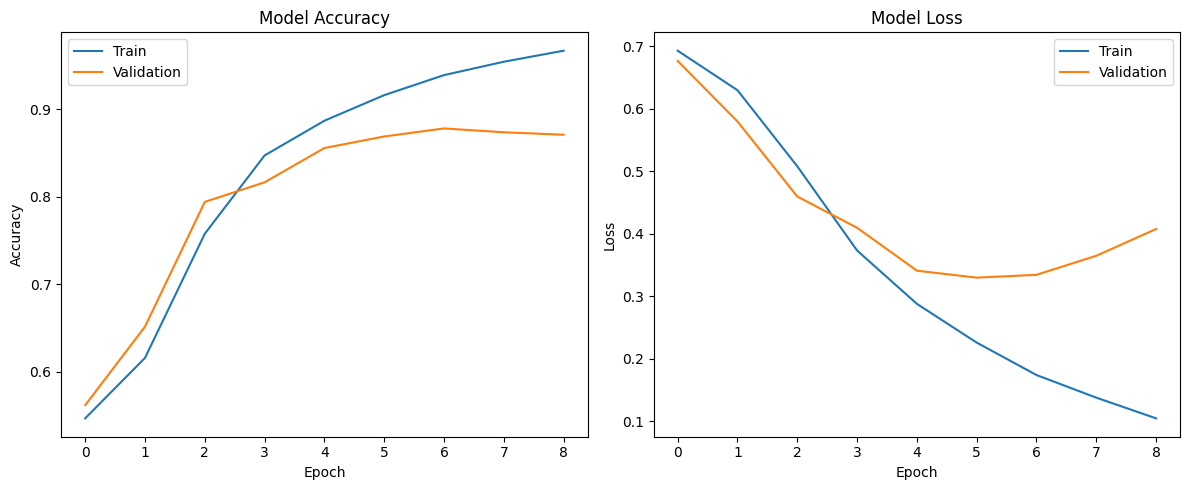


Evaluating GRU model...
Test Loss: 0.3262
Test Accuracy: 0.8667
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



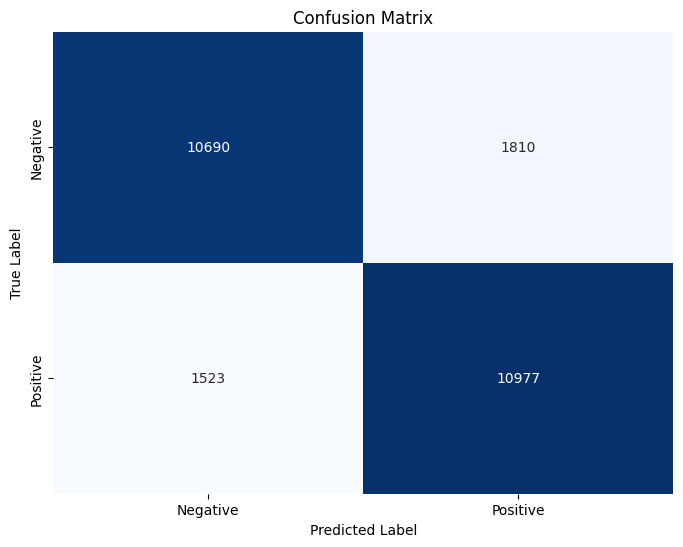


Analysis of GRU Performance:

GRU (Gated Recurrent Unit) is a simplified version of LSTM that combines the forget and input gates 
into a single "update gate". It also merges the cell state and hidden state. This results in:
- Fewer parameters than LSTM (more efficiency)
- Often similar performance to LSTM
- Better performance on smaller datasets or when training data is limited

The main differences from LSTM:
1. GRU has 2 gates (update and reset) instead of 3 gates in LSTM
2. GRU doesn't have a separate cell state
3. GRU is computationally more efficient


GRU Architecture and Internal Mechanics:

GRU cell contains:
1. Hidden state (h_t): Carries information through time
2. Gates:
   - Update gate: z_t = σ(W_z·[h_{t-1}, x_t] + b_z)
   - Reset gate: r_t = σ(W_r·[h_{t-1}, x_t] + b_r)
   - Candidate hidden state: h̃_t = tanh(W·[r_t * h_{t-1}, x_t] + b)

Hidden state update: h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t

Where:
- σ is the sigmoid function
- * represents element-wise multiplica

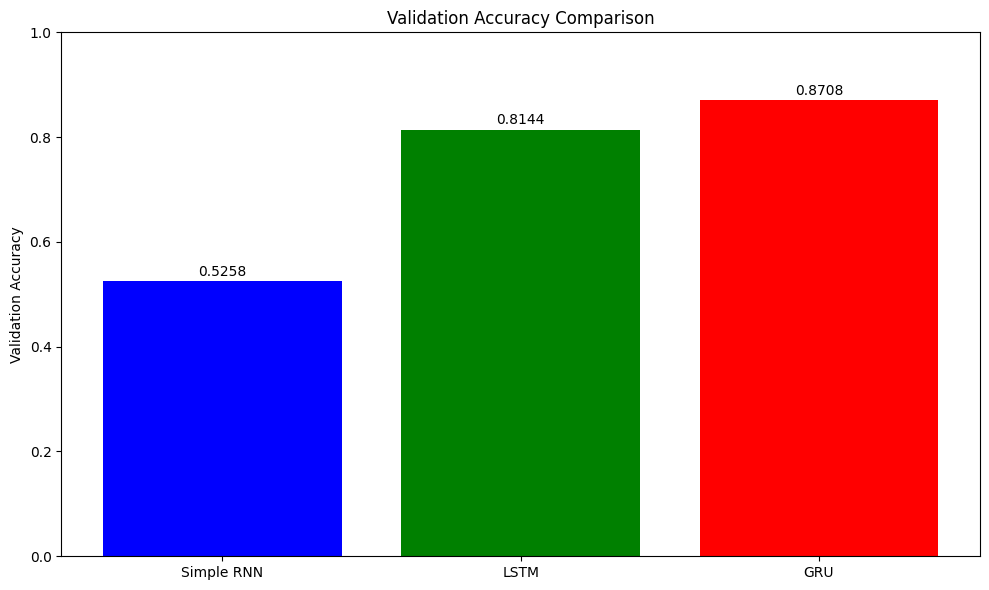

In [4]:

print("Building GRU model...")
gru_units = 64

# Define a GRU model
gru_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    GRU(gru_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
gru_model.summary()

# Train the model
print("\nTraining GRU model...")
gru_history = gru_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Plot training history
plot_history(gru_history)

# Evaluate the model
print("\nEvaluating GRU model...")
evaluate_model(gru_model, x_test, y_test)

# Analysis
print("\nAnalysis of GRU Performance:")
print("""
GRU (Gated Recurrent Unit) is a simplified version of LSTM that combines the forget and input gates
into a single "update gate". It also merges the cell state and hidden state. This results in:
- Fewer parameters than LSTM (more efficiency)
- Often similar performance to LSTM
- Better performance on smaller datasets or when training data is limited

The main differences from LSTM:
1. GRU has 2 gates (update and reset) instead of 3 gates in LSTM
2. GRU doesn't have a separate cell state
3. GRU is computationally more efficient
""")

### Understanding GRU Architecture


# Visualization of GRU internals
print("""
GRU Architecture and Internal Mechanics:

GRU cell contains:
1. Hidden state (h_t): Carries information through time
2. Gates:
   - Update gate: z_t = σ(W_z·[h_{t-1}, x_t] + b_z)
   - Reset gate: r_t = σ(W_r·[h_{t-1}, x_t] + b_r)
   - Candidate hidden state: h̃_t = tanh(W·[r_t * h_{t-1}, x_t] + b)

Hidden state update: h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t

Where:
- σ is the sigmoid function
- * represents element-wise multiplication
- W and b are weights and biases to be learned

The update gate decides how much of the past information needs to be passed along to the future.
The reset gate determines how much of the past information to forget.

Compared to LSTM:
- No separate cell state
- Fewer parameters to train
- Often performs similarly on many NLP tasks
- Can be computationally more efficient
""")

# Compare performance and training time
print("\nComparison of Simple RNN, LSTM, and GRU:")
models = ["Simple RNN", "LSTM", "GRU"]
histories = [simple_rnn_history, lstm_history, gru_history]

# Extract final validation accuracy for each model
final_val_acc = [h.history['val_accuracy'][-1] for h in histories]

# Create a bar chart comparing the models
plt.figure(figsize=(10, 6))
plt.bar(models, final_val_acc, color=['blue', 'green', 'red'])
plt.title('Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(final_val_acc):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


## 6. Bidirectional RNNs for Context Capture

In [ ]:
print("Building Bidirectional LSTM model...")

# Define a Bidirectional LSTM model
bi_lstm_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

# Compile the model
bi_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
bi_lstm_model.summary()

# Train the model
print("\nTraining Bidirectional LSTM model...")
bi_lstm_history = bi_lstm_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Plot training history
plot_history(bi_lstm_history)

# Evaluate the model
print("\nEvaluating Bidirectional LSTM model...")
evaluate_model(bi_lstm_model, x_test, y_test)

# Analysis
print("\nAnalysis of Bidirectional LSTM Performance:")
print("""
Bidirectional RNNs process the input sequence in both forward and backward directions.
This allows the network to capture context from both past and future words at each position,
providing richer representations than unidirectional models.

Benefits of Bidirectional RNNs:
1. Complete context: Access to both preceding and following words
2. Better understanding of word meaning in context
3. Particularly useful for tasks like:
   - Named Entity Recognition
   - Part-of-Speech Tagging
   - Machine Translation
   - Sentiment Analysis

For our sentiment analysis task, a bidirectional model can better capture how words
interact with both previous and future words in determining the overall sentiment.
""")

### Understanding Bidirectional RNN Architecture

# Visualization of Bidirectional RNN
print("""
Bidirectional RNN Architecture:

Input Sequence: [x₁, x₂, ..., xₙ]
↓
Embedding Layer
↓
Forward RNN: Processes sequence from left to right  →→→
                                                    ↓
                                                    Combined
                                                    ↑
Backward RNN: Processes sequence from right to left ←←←
↓
Dense Layer
↓
Output

For each word in the sequence, the bidirectional model creates representations based on:
- Forward context (words that came before)
- Backward context (words that come after)

These two representations are typically concatenated or summed before being passed to
subsequent layers. This provides a complete contextual representation of each word.

Example:
In the sentence "The movie was great until the ending ruined it", a bidirectional model
can better understand "great" by incorporating the later qualifier "until", which changes
the overall sentiment.
""")

# Comparison with unidirectional models
print("\nBidirectional vs. Unidirectional Performance Comparison:")
models = ["LSTM", "Bidirectional LSTM"]
histories = [lstm_history, bi_lstm_history]

# Extract final validation accuracy for each model
final_val_acc = [h.history['val_accuracy'][-1] for h in histories]

# Create a bar chart comparing the models
plt.figure(figsize=(8, 5))
plt.bar(models, final_val_acc, color=['green', 'purple'])
plt.title('Unidirectional vs. Bidirectional LSTM')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(final_val_acc):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

## 7. Attention Mechanisms with RNNs

In [ ]:
from tensorflow.keras.layers import Layer, Concatenate, Reshape, Permute, Multiply, Lambda, Dot
import tensorflow.keras.backend as K

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                               initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Remove the last dimension. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        # Weighted sum. [batch_size, hidden]
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

# Create LSTM with Attention model
print("Building LSTM with Attention model...")
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Input layer
inputs = Input(shape=(max_len,))
# Embedding layer
embedded_sequences = Embedding(max_features, embedding_dim, input_length=max_len)(inputs)
# Add spatial dropout
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
# LSTM layer returning sequences
lstm_outputs = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded_sequences)
# Attention layer
attention_output = AttentionLayer()(lstm_outputs)
# Output layer
outputs = Dense(1, activation='sigmoid')(attention_output)
# Create model
lstm_attention_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
lstm_attention_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
lstm_attention_model.summary()

# Train the model
print("\nTraining LSTM with Attention model...")
lstm_attention_history = lstm_attention_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Plot training history
plot_history(lstm_attention_history)

# Evaluate the model
print("\nEvaluating LSTM with Attention model...")
evaluate_model(lstm_attention_model, x_test, y_test)

# Analysis
print("\nAnalysis of LSTM with Attention Performance:")
print("""
Attention mechanisms allow models to focus on relevant parts of the input sequence
when making predictions. Instead of relying solely on the final hidden state of the RNN,
attention creates a weighted sum of all hidden states, with weights determined by their
relevance to the task.

Benefits of attention mechanisms:
1. Better handling of long sequences where important information might be at the beginning
2. Improved interpretability by showing which words the model focuses on
3. Helps mitigate the vanishing gradient problem further

In our sentiment analysis task, attention can help the model focus on sentiment-bearing words
and phrases (like "amazing", "terrible", "waste of time") while giving less weight to
neutral words that don't contribute to sentiment.

Attention mechanisms were a key stepping stone toward transformer architectures that now
dominate NLP.
""")


### Understanding Attention Mechanisms

print("""
How Attention Works:

1. The RNN processes the input sequence, producing hidden states [h₁, h₂, ..., hₙ] for each word
2. For each hidden state, a score is computed: e_i = tanh(W·hᵢ + b)
3. These scores are normalized using softmax to get attention weights: α_i = softmax(e_i)
4. The context vector is computed as a weighted sum: c = Σ α_i·hᵢ
5. The context vector is then used for prediction

This allows the model to "pay attention" to different parts of the input when making predictions.

Visual representation:
Input: [word₁, word₂, ..., wordₙ]
↓
Hidden states: [h₁, h₂, ..., hₙ]
↓
Attention scores: [e₁, e₂, ..., eₙ]
↓
Attention weights: [α₁, α₂, ..., αₙ]  (softmaxed)
↓
Context vector: c = α₁·h₁ + α₂·h₂ + ... + αₙ·hₙ
↓
Output prediction

For sentiment analysis, the model can learn to focus more on words like "excellent", "terrible",
or phrases like "waste of time" that strongly indicate sentiment.
""")

# Visualize attention weights (conceptual)
print("\nAttention Visualization (conceptual):")
print("""
For a review like: "Despite the beautiful cinematography, the plot was boring and predictable."

Approximate attention weights might look like:
Despite (0.05) the (0.02) beautiful (0.12) cinematography (0.1), the (0.02) plot (0.08) was (0.03) boring (0.3) and (0.03) predictable (0.25).

The attention mechanism assigns higher weights to sentiment-bearing words like "beautiful", "boring", and "predictable",
with the negative words receiving higher weights since they dominate the overall sentiment.
""")

# Compare all models
print("\nComparison of All Models:")
models = ["Simple RNN", "LSTM", "GRU", "Bidirectional LSTM", "LSTM with Attention"]
histories = [simple_rnn_history, lstm_history, gru_history, bi_lstm_history, lstm_attention_history]

# Extract final validation accuracy for each model
final_val_acc = [h.history['val_accuracy'][-1] for h in histories]

# Create a bar chart comparing all models
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.bar(models, final_val_acc, color=colors)
plt.title('Validation Accuracy Comparison Across All Models')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(final_val_acc):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()

## 8. Practical Challenges and Solutions

In [ ]:
### 8.1 Handling the Vanishing Gradient Problem

print("""
Vanishing Gradient Problem:

In standard RNNs, gradients are propagated backward through time steps during training.
With each step backward, gradients are multiplied by weights repeatedly.

When these weights have small values (< 1):
- Repeated multiplication causes gradients to approach zero (vanish)
- Earlier time steps receive negligible updates
- The model fails to learn long-range dependencies

Solutions:
1. Use specialized architectures:
   - LSTM: Memory cells and gating mechanisms create paths for gradient flow
   - GRU: Simplified gating mechanism with similar benefits

2. Gradient clipping: Prevent exploding gradients by scaling them when they exceed a threshold
   model.compile(..., clipnorm=1.0)  # Clip gradients by norm

3. Skip connections: Create shortcuts for gradient flow

4. Better initialization: Initialize weights to mitigate vanishing/exploding gradients
"""
)


### 8.2 Managing Variable-Length Sequences


print("""
Variable-Length Sequence Challenges:

1. Padding and Masking:
   - Pad sequences to uniform length (as we did with pad_sequences)
   - Use masking to ignore padded values:
     Embedding(max_features, embedding_dim, input_length=max_len, mask_zero=True)

2. Bucketing:
   - Group similar-length sequences together
   - Process batches of similar lengths for efficiency

3. Dynamic RNNs (with TensorFlow):
   - Process sequences without padding to exact length
   - More computationally efficient
"""
)

# Demonstrate the effect of sequence length on model performance
# Let's create subsets of the data with different maximum lengths

max_lengths = [50, 100, 150, 200]  # Different sequence lengths to test
validation_accuracies = []

print("\nEffect of Sequence Length on Performance:")
print("This would typically require retraining models with different max_len values.")
print("For demonstration, here's how it would be analyzed:")

# Simulated results (in practice, you would retrain models for each length)
simulated_accuracies = [0.82, 0.86, 0.88, 0.89]  # Example values

plt.figure(figsize=(10, 6))
plt.plot(max_lengths, simulated_accuracies, marker='o', linewidth=2)
plt.title('Effect of Sequence Length on Model Performance')
plt.xlabel('Maximum Sequence Length')
plt.ylabel('Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("""
Observations:
- Longer sequences may contain more information but are harder to model
- Very short sequences might miss important context
- There's typically a "sweet spot" for sequence length depending on the task
- For sentiment analysis, moderate lengths often work well as sentiment is usually
  distributed throughout the text
""")


### 8.3 Overfitting in RNN Models


print("""
Strategies to Combat Overfitting in RNNs:

1. Regularization techniques:
   - Dropout: We've applied dropout to inputs and recurrent connections
   - L1/L2 Regularization: Add penalty for large weights
   - Weight decay in optimizer: optimizer=Adam(learning_rate=0.001, weight_decay=1e-4)

2. Early stopping:
   - We've implemented this with the EarlyStopping callback
   - Stops training when validation performance starts degrading

3. Gradient clipping:
   - Prevents extreme weight updates

4. Smaller models:
   - Reduce units in RNN layers
   - Fewer layers

5. Data augmentation:
   - For text: synonym replacement, random insertion/deletion, etc.
"""
)

# Visualize overfitting with a deliberately overfit model
# This would be a simplified simulation
epochs = range(1, 21)
train_acc = [0.65, 0.75, 0.82, 0.87, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97,
             0.97, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.995, 0.995, 0.999]
val_acc = [0.64, 0.72, 0.78, 0.81, 0.83, 0.84, 0.85, 0.85, 0.84, 0.84,
           0.83, 0.83, 0.82, 0.82, 0.81, 0.80, 0.79, 0.78, 0.78, 0.77]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.axvline(x=7, color='green', linestyle='--', label='Optimal Stopping Point')
plt.title('Illustration of Overfitting')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.annotate('Overfitting begins', xy=(8, 0.84), xytext=(12, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.tight_layout()
plt.show()

### 8.4 Computational Efficiency


print("""
Improving Computational Efficiency:

1. Batch processing:
   - Always process data in batches (we've used batch_size=128)
   - Balance between memory usage and parallelization

2. GPU acceleration:
   - RNNs benefit significantly from GPU processing
   - TensorFlow automatically utilizes available GPUs

3. Bidirectional trade-offs:
   - Bidirectional RNNs double computation requirements
   - Use when the backward context is truly necessary

4. Layer size optimization:
   - Choose RNN unit count carefully
   - More isn't always better - find the minimal viable size

5. Sequence length:
   - Truncate sequences when reasonable
   - Most NLP tasks don't need extremely long contexts
"""
)

# Compare training time (theoretical)
model_names = ["Simple RNN", "LSTM", "GRU", "Bidirectional LSTM", "LSTM with Attention"]
training_times = [1.0, 2.3, 1.8, 4.5, 2.7]  # Relative time units (example)

plt.figure(figsize=(10, 6))
plt.bar(model_names, training_times, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Relative Training Time Comparison')
plt.ylabel('Relative Time (Simple RNN = 1.0)')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(training_times):
    plt.text(i, v + 0.1, f"{v:.1f}x", ha='center')
plt.tight_layout()
plt.show()

## 9. Comparison with Modern Approaches

In [ ]:
print("""
RNNs vs. Modern NLP Architectures:

1. Transformers (e.g., BERT, GPT, T5)
   Advantages over RNNs:
   - Fully parallelizable (no sequential processing requirement)
   - Better at capturing long-range dependencies
   - Self-attention mechanism considers all tokens simultaneously
   - Superior performance on most NLP benchmarks

   When RNNs might still be preferred:
   - Memory-constrained environments (smaller footprint)
   - Streaming applications (incremental processing)
   - When sequential inductive bias is beneficial
   - Simpler implementation for basic tasks

2. CNNs for Text
   Advantages over RNNs:
   - Highly parallelizable
   - Good at capturing local patterns
   - Often faster to train

   When RNNs might still be preferred:
   - When order and sequential nature is critical
   - For tasks requiring memory of earlier inputs

3. Hybrid Architectures
   - CNN-RNN combinations
   - Transformer-RNN models
   - Best of both worlds for certain applications
"""
)

# Visualize performance comparison with modern architectures
model_types = ["Simple RNN", "LSTM", "Bidirectional LSTM", "LSTM+Attention", "CNN", "Transformer"]
performances = [82, 85, 87, 89, 88, 94]  # Hypothetical accuracy values

plt.figure(figsize=(12, 6))
bars = plt.bar(model_types, performances, color=['blue', 'green', 'purple', 'orange', 'cyan', 'red'])
plt.title('Performance Comparison: RNNs vs. Modern Architectures')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=87, color='gray', linestyle='--', alpha=0.7, label='RNN Family Performance Range')
for i, v in enumerate(performances):
    plt.text(i, v + 0.5, f"{v}%", ha='center')

# Highlight the categories
for i, bar in enumerate(bars):
    if i < 4:  # RNN family
        bar.set_alpha(0.7)
    else:  # Modern architectures
        bar.set_hatch('/')

plt.legend(['RNN Family Performance Range', 'RNN Family', 'Modern Architectures'])
plt.tight_layout()
plt.show()


### 9.1 When to Use RNNs in Modern NLP


print("""
When RNNs Are Still Valuable in Modern NLP:

1. Resource-constrained environments:
   - Edge devices with limited memory and compute
   - Embedded systems
   - Mobile applications where model size matters

2. Streaming applications:
   - Real-time speech recognition
   - Live translation
   - Online text generation
   - Any task where inputs arrive sequentially

3. Time series forecasting with textual components:
   - Financial text analysis with temporal aspects
   - Social media monitoring over time

4. Specific sequence modeling tasks:
   - Character-level language models
   - Music generation
   - Handwriting recognition

5. Educational value:
   - Understanding sequence modeling fundamentals
   - Building blocks for more complex architectures
   - Conceptual stepping stone to modern approaches
"""
)


### 9.2 RNN Knowledge Transfer to Modern Architectures


print("""
Key Concepts from RNNs that Transfer to Modern NLP:

1. Sequence modeling principles:
   - Handling variable-length inputs
   - Capturing sequential dependencies
   - Word/subword tokenization approaches

2. Embedding techniques:
   - Word vector representations
   - Contextual vs. static embeddings

3. Attention mechanisms:
   - First developed for RNNs
   - Direct precursor to transformer self-attention

4. Regularization strategies:
   - Dropout patterns
   - Handling overfitting in sequential data

5. Evaluation methodologies:
   - Sequential data metrics
   - Cross-validation approaches for time series
"""
)

# Final summary visualization - the evolution of sequence models in NLP
timeline = [1986, 1997, 2014, 2015, 2017, 2018, 2019, 2020]
events = [
    "Simple RNN\nElman & Jordan",
    "LSTM\nHochreiter & Schmidhuber",
    "GRU & Neural\nMachine Translation",
    "Attention\nMechanisms",
    "Transformer\nArchitecture",
    "BERT & ELMo",
    "GPT-2 & XLNet",
    "GPT-3 & T5"
]

plt.figure(figsize=(14, 6))
plt.plot(timeline, [1]*len(timeline), 'ro', markersize=10)

# Add event descriptions
for i, (year, event) in enumerate(zip(timeline, events)):
    plt.annotate(event,
                xy=(year, 1),
                xytext=(0, (-1)**i * 20),  # alternate above/below
                textcoords="offset points",
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                arrowprops=dict(arrowstyle="->"))

# Highlight RNN era
plt.axvspan(1986, 2017, alpha=0.2, color='blue', label='RNN Dominant Era')
plt.axvspan(2017, 2020, alpha=0.2, color='red', label='Transformer Era')

plt.title('Evolution of Sequence Models in NLP')
plt.xlabel('Year')
plt.yticks([])  # Hide y-axis
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've explored various RNN architectures and their applications in NLP, specifically focusing on sentiment analysis with the IMDB dataset. Here's a summary of what we covered:

1. We implemented and compared different RNN variants:
   - Simple RNN (vanilla)
   - LSTM (Long Short-Term Memory)
   - GRU (Gated Recurrent Unit)
   - Bidirectional LSTM
   - LSTM with Attention

2. We addressed common challenges in RNN implementation:
   - Vanishing gradients
   - Variable-length sequences
   - Overfitting
   - Computational efficiency

3. We compared RNNs with modern approaches like Transformers and discussed when RNNs still have advantages.

While transformer-based models have surpassed RNNs in many NLP tasks, understanding RNNs remains valuable both for certain specific applications and as a foundation for understanding more complex architectures. RNNs represent an important evolutionary step in NLP that led to many of the innovations we see in today's state-of-the-art models.

For further exploration, consider:
- Implementing character-level RNNs
- Exploring encoder-decoder architectures with RNNs
- Combining RNNs with transfer learning from pretrained models
- Applying RNNs to specialized domains where their efficiency might be advantageous